 # Iterative Projection of a 2D Function



 In this notebook we:



 1. Import necessary libraries.

 2. Define helper functions for plotting.

 3. Define the function `project_to_separable` which approximates a 2D function by a separable function \(m(x_1,x_2) \approx m_1(x_1) m_2(x_2)\) using an alternating update procedure.

 4. Define `iterative_projection` which repeatedly projects the residual onto a separable function, accumulating a rank‑1 approximation at each epoch.

 5. Define a target function and run the iterative projection procedure.

 6. Finally, plot a final comparison of the original function, overall approximation, and residual.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

true_model3 = lambda x1, x2: np.exp(np.sin(x1) * np.cos(x2)) + x1


 ### L2 Identification Function



 This function normalizes a 1D component using uniform weights. If the component is sign‐changing,

 it uses L² normalization (adjusted by the sign of the mean); otherwise, it uses the mean.

 It returns the normalized component and its scaling factor.

In [11]:
def l2_identification(component):
    n = component.shape[0]
    weights = np.ones(n)  # uniform weights
    weights_sum = n        # sum of ones is n
    mean = np.sum(weights * component) / weights_sum
    # Check if the component contains both negative and positive values.
    if np.any(component < 0) and np.any(component > 0):
        scale = np.sign(mean) * np.sqrt(np.sum(weights * component**2) / weights_sum)
    else:
        scale = mean
    normalized_component = component / scale
    return normalized_component, scale


 ## Helper Function: Plot Epoch Results



 This function plots the current rank‑1 approximation (as a contour plot), the residual, and the extracted 1D functions \(m_1(x_1)\) and \(m_2(x_2)\) for a given epoch.

In [12]:
def plot_epoch_results(x1_grid, x2_grid, M_approx_epoch, R, epoch, m1, m2, scaling, M_true):
    """
    Plots the current rank-1 approximation, residual and 1D components.

    Parameters:
      x1_grid, x2_grid : 1D numpy arrays for the grid.
      M_approx_epoch : 2D numpy array for the current approximation.
      R : 2D numpy array for the current residual.
      epoch : int, current epoch number.
      m1 : 1D numpy array for m1(x1).
      m2 : 1D numpy array for m2(x2).
      scaling : float, scaling factor for the components.
      M_true : 2D numpy array, the true function evaluated on the grid.
    """
    # Create a meshgrid for contour plotting
    X1, X2 = np.meshgrid(x1_grid, x2_grid, indexing='ij')

    # Plot contour of the current approximation and the residual
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    contour0 = axes[0].contourf(X1, X2, M_true, levels=20, cmap='seismic')
    plt.colorbar(contour0, ax=axes[0])
    axes[0].set_title(f'Original m(x1, x2)')
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')
    axes[0].grid(True)

    contour1 = axes[1].contourf(X1, X2, M_approx_epoch, levels=20, cmap='viridis')
    plt.colorbar(contour1, ax=axes[1])
    axes[1].set_title(f'Epoch {epoch}: Approximation')
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')
    axes[1].grid(True)

    contour2 = axes[2].contourf(X1, X2, R, levels=20, cmap='viridis')
    plt.colorbar(contour2, ax=axes[2])
    axes[2].set_title(f'Epoch {epoch}: Residual r(x1,x2)')
    axes[2].set_xlabel('x1')
    axes[2].set_ylabel('x2')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Plot the 1D components
    plt.figure(figsize=(12, 5))
    plt.plot(x1_grid, m1, label='m1(x1)')
    plt.plot(x2_grid, m2, label='m2(x2)')
    plt.xlabel('x1 or x2')
    plt.ylabel('Component value')
    plt.title(f'Epoch {epoch}: 1D Components (scaling={scaling:.3f})')
    plt.legend()
    plt.grid(True)  # Add grid to 1D plots
    plt.show()


 ## Function: Project to Separable



 This function approximates a 2D function \( m(x_1,x_2) \) by a separable function of the form



 \[

 m(x_1,x_2) \approx m_1(x_1) m_2(x_2)

 \]



 using an alternating least squares type iterative procedure.



 The function creates a grid, evaluates \( m \) on that grid, initializes \( m_1 \) and \( m_2 \) using the marginal averages, and then iteratively updates them until convergence.

In [13]:
def project_to_separable(m_func, x1_range=(-3, 3), x2_range=(-3, 3), num_points=100, tol=1e-6, max_iter=1000):
    """
    Approximates a 2D function m(x1,x2) by a separable function m1(x1)*m2(x2)
    using an alternating update procedure.

    Parameters:
      m_func : callable
          A function that accepts two arrays (X1, X2) and returns a 2D array of shape (num_points, num_points).
      x1_range : tuple
          Range (min, max) for x1.
      x2_range : tuple
          Range (min, max) for x2.
      num_points : int
          Number of grid points along each axis.
      tol : float
          Convergence tolerance.
      max_iter : int
          Maximum number of iterations.

    Returns:
      x1 : 1D numpy array (grid for x1).
      x2 : 1D numpy array (grid for x2).
      m1 : 1D numpy array approximating m1(x1).
      m2 : 1D numpy array approximating m2(x2).
      M  : 2D numpy array with m_func evaluated on the grid.
      scaling : float, overall scaling factor.
    """
    # Create grid of points
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    x2 = np.linspace(x2_range[0], x2_range[1], num_points)
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')

    # Evaluate the function on the grid
    M = m_func(X1, X2)

    # Initialize m1 and m2 using marginal averages
    m1 = np.mean(M, axis=1)  # average over x2 (for each x1)
    m2 = np.mean(M, axis=0)  # average over x1 (for each x2)

    # Alternating updates
    for it in range(max_iter):
        m1_old = m1.copy()
        m2_old = m2.copy()

        # Update m1: for each x1 value:
        m1 = np.sum(M * m2_old[np.newaxis, :], axis=1) / (np.sum(m2_old ** 2))
        # Update m2: for each x2 value:
        m2 = np.sum(M * m1[:, np.newaxis], axis=0) / (np.sum(m1 ** 2))

        # Check convergence using the L2 norm of changes
        if np.linalg.norm(m1 - m1_old) < tol and np.linalg.norm(m2 - m2_old) < tol:
            print(f"Converged after {it} iterations")
            break

    m1_norm, scale1 = l2_identification(m1)
    m2_norm, scale2 = l2_identification(m2)
    scaling = scale1 * scale2  # overall scaling factor
    
    return x1, x2, m1_norm, m2_norm, M, scaling


 ## Function: Iterative Projection



 This function iteratively projects a 2D function \( m(x_1,x_2) \) onto a sum of separable components. In each epoch:



 - It projects the current residual onto a separable function using `project_to_separable`.

 - It computes a rank‑1 approximation \( m_1(x_1) m_2(x_2) \) and updates the overall approximation.

 - It then subtracts the current approximation from the residual.

 - Optionally, it plots the current approximation, residual, and the extracted 1D components.



 The final output includes the overall approximation, the final residual, and a list of the univariate component pairs for each epoch.

In [14]:
def iterative_projection(m_func, n_epochs=5, x1_range=(-3, 3), x2_range=(-3, 3),
                         num_points=100, tol=1e-6, max_iter=1000, plot=True):
    """
    Iteratively projects a 2D function m(x1,x2) onto a sum of separable components.
    In each epoch, it projects the current residual onto a separable function and updates the residual.

    Parameters:
      m_func : callable
          The original 2D function m(x1, x2).
      n_epochs : int
          Number of epochs (iterations) to perform.
      x1_range, x2_range : tuple
          The ranges for x1 and x2.
      num_points : int
          Number of grid points along each axis.
      tol : float
          Tolerance for the separable projection procedure.
      max_iter : int
          Maximum iterations for the separable projection.
      plot : bool
          If True, plot the results at each epoch.

    Returns:
      overall_approx : 2D numpy array, the sum of all separable approximations.
      R : 2D numpy array, the final residual.
      components : list of tuples, each tuple is (m1, m2) for that epoch.
    """
    # Create a grid that will be used throughout the procedure
    x1_grid = np.linspace(x1_range[0], x1_range[1], num_points)
    x2_grid = np.linspace(x2_range[0], x2_range[1], num_points)
    X1, X2 = np.meshgrid(x1_grid, x2_grid, indexing='ij')

    # Evaluate the original function on the grid
    M_original = m_func(X1, X2)

    # Initialize residual and overall approximation
    R = M_original.copy()
    overall_approx = np.zeros_like(R)
    components = []

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}, max residual = {np.max(np.abs(R))}")
        # Define a function that returns the current residual R.
        # Note: project_to_separable will build its own grid internally,
        # so we simply ignore its input and return R.
        current_func = lambda X1, X2, res=R: res

        # Project the current residual onto a separable function.
        x1_grid, x2_grid, m1, m2, _, scaling = project_to_separable(
            current_func, x1_range=x1_range, x2_range=x2_range, num_points=num_points, tol=tol, max_iter=max_iter)

        # Compute the rank-1 separable approximation from the extracted 1D functions.
        M_approx_epoch = scaling * np.outer(m1, m2)
        overall_approx += M_approx_epoch
        components.append((m1, m2))

        # Update the residual
        R = R - M_approx_epoch
        print(f"min(m1) = {np.min(m1)}, min(m2) = {np.min(m2)}, residual norm = {np.linalg.norm(R)}")

        # Optionally plot the results for the current epoch
        if plot:
            plot_epoch_results(x1_grid, x2_grid, overall_approx, R, epoch, m1, m2, scaling, M_original)

    return overall_approx, R, components


 ## Define the Target Function and Run the Projection



 Here we define a sample 2D function and run the iterative projection algorithm. After the iterative process is complete, we plot a final comparison of the original function, the overall approximation, and the final residual.

Epoch 1, max residual = 58.0
Converged after 5 iterations
min(m1) = 0.887485358804428, min(m2) = 0.6695467616543319, residual norm = 668.7051626883605


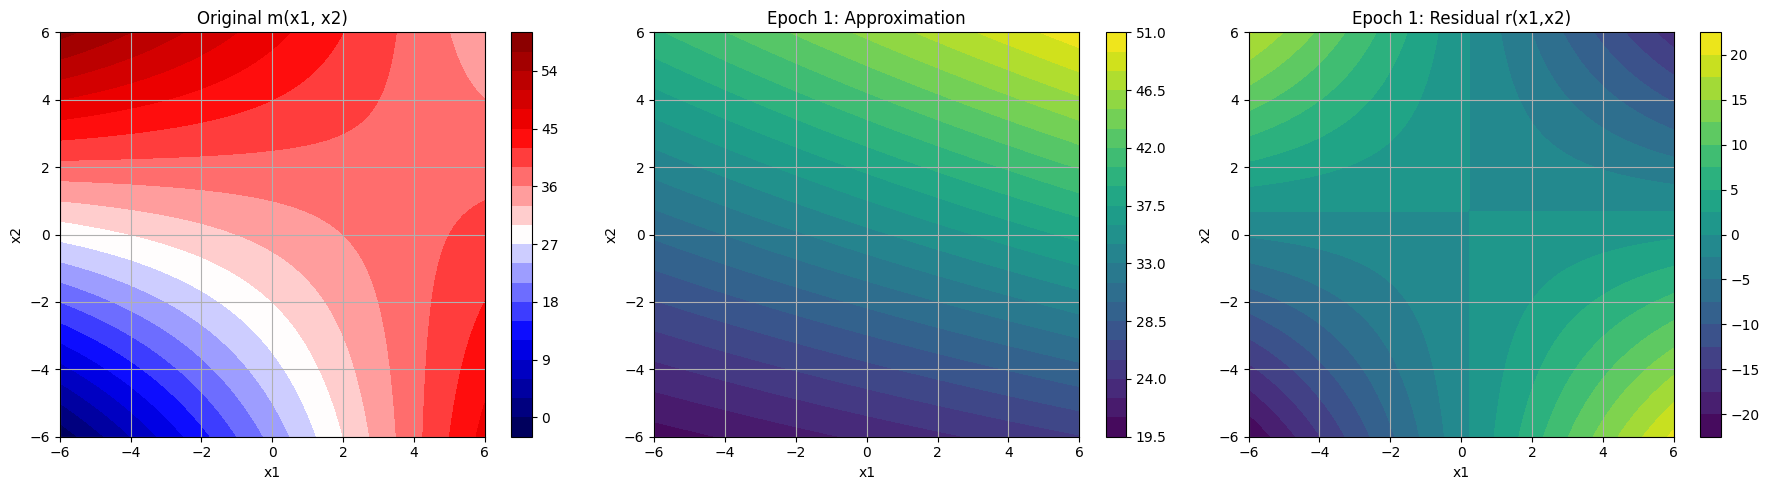

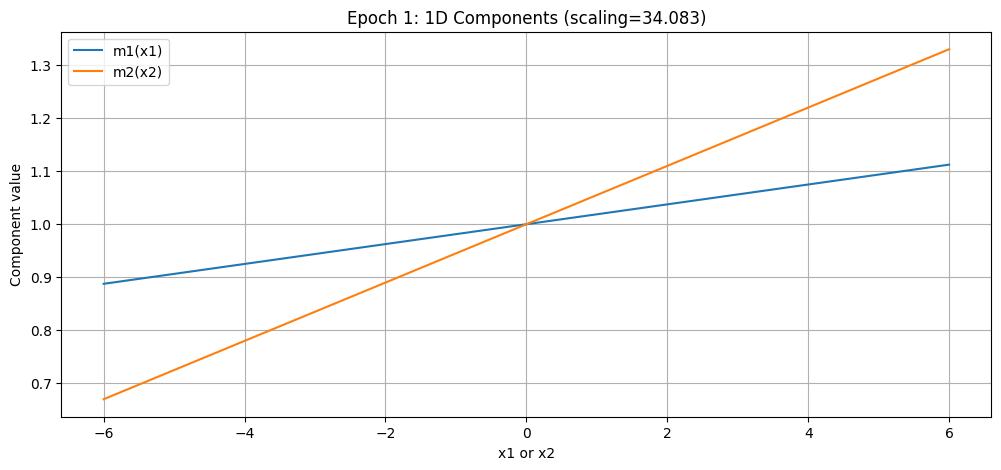

Epoch 2, max residual = 22.252468013023297
Converged after 1 iterations
min(m1) = -1.6456642315268026, min(m2) = -1.4946129065268432, residual norm = 1.1649412629399173e-12


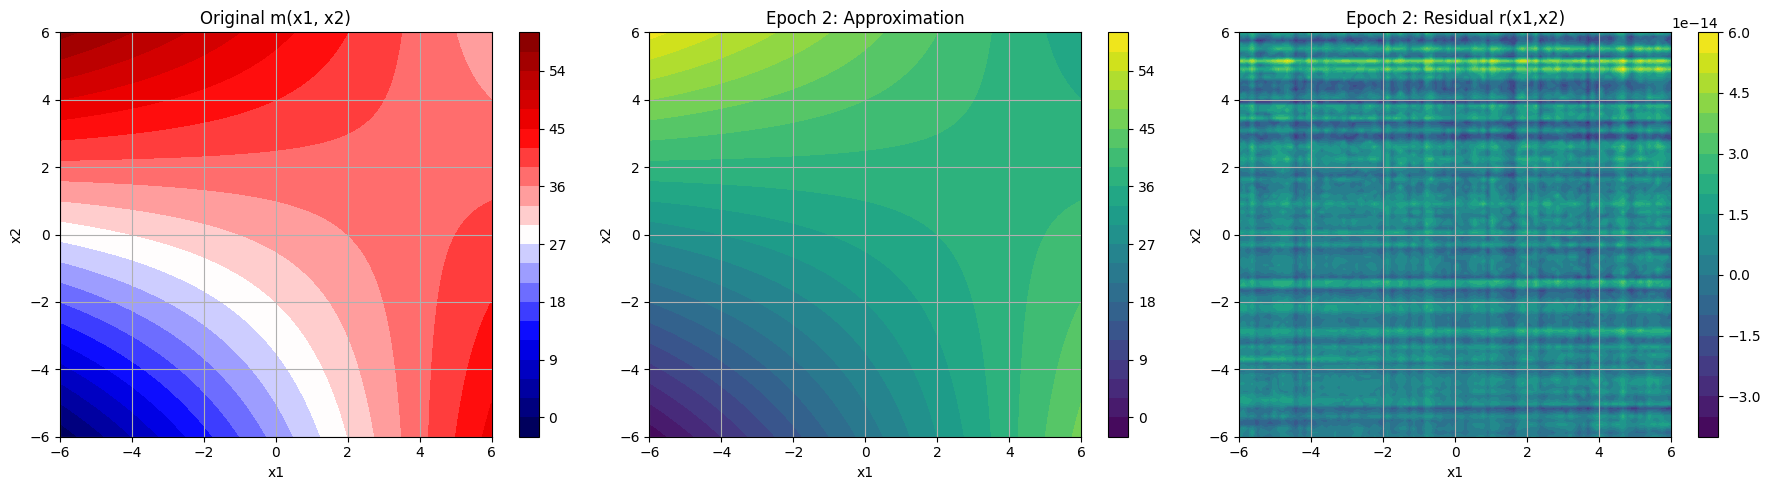

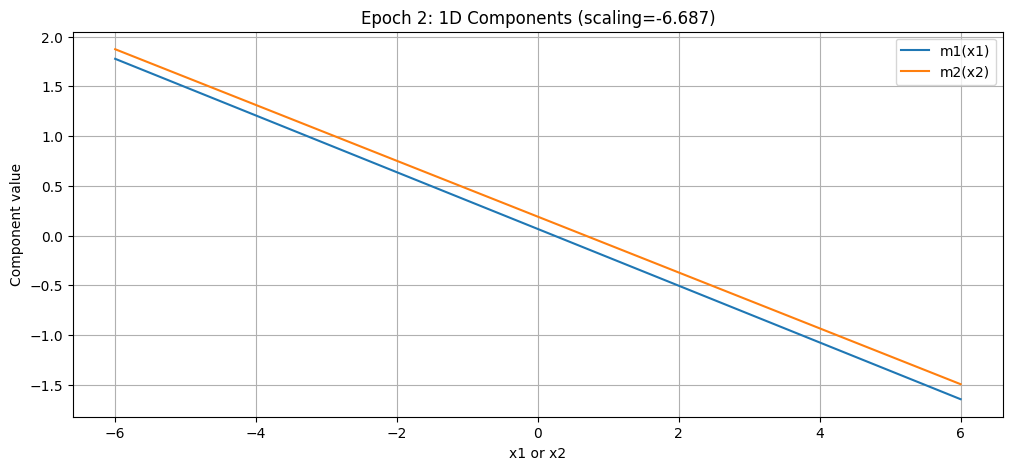

Epoch 3, max residual = 5.684341886080802e-14
Converged after 7 iterations
min(m1) = 0.5574435618735929, min(m2) = -2.0630455848444647, residual norm = 5.16347884428739e-13


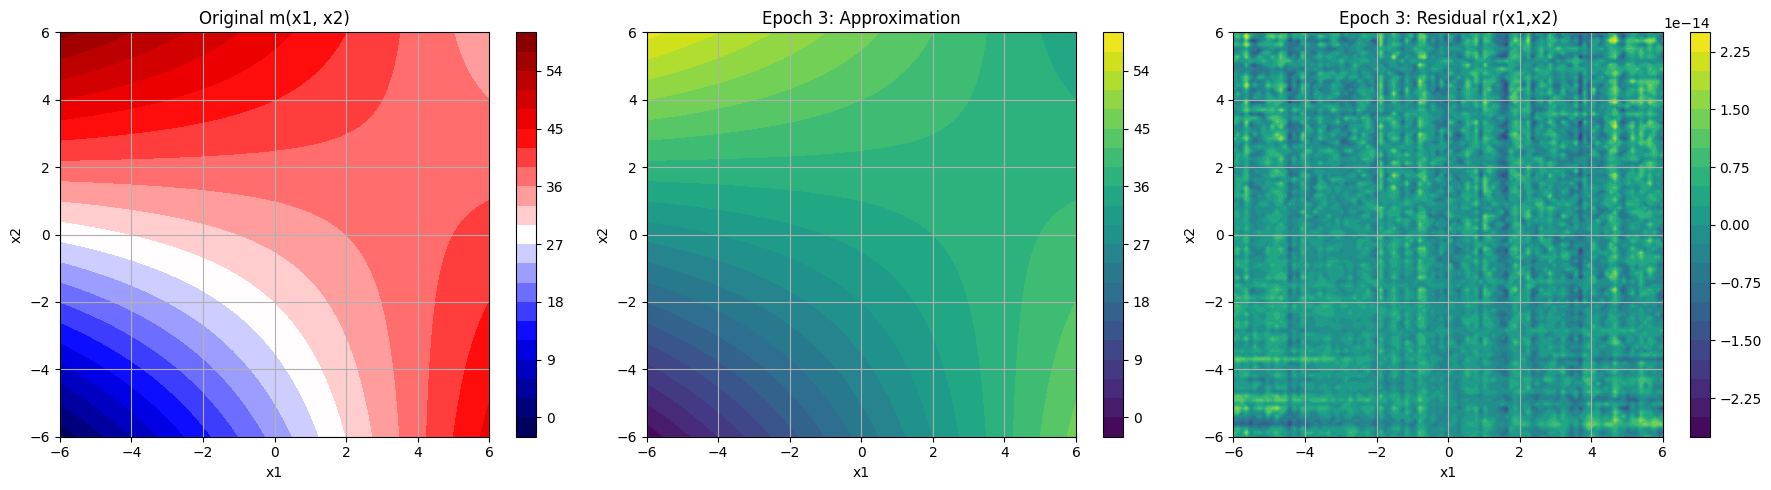

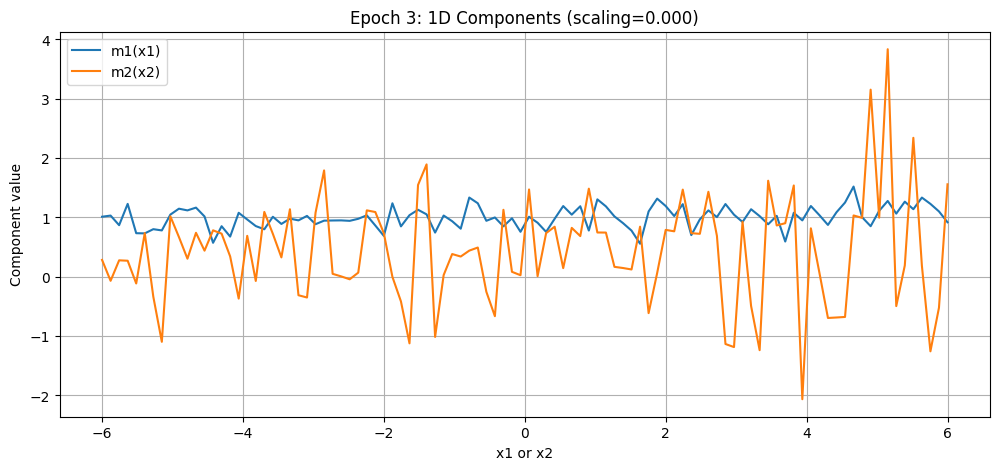

Epoch 4, max residual = 2.7084930796428232e-14
Converged after 13 iterations
min(m1) = -2.18419193717849, min(m2) = -0.2860328625932337, residual norm = 3.660830442936024e-13


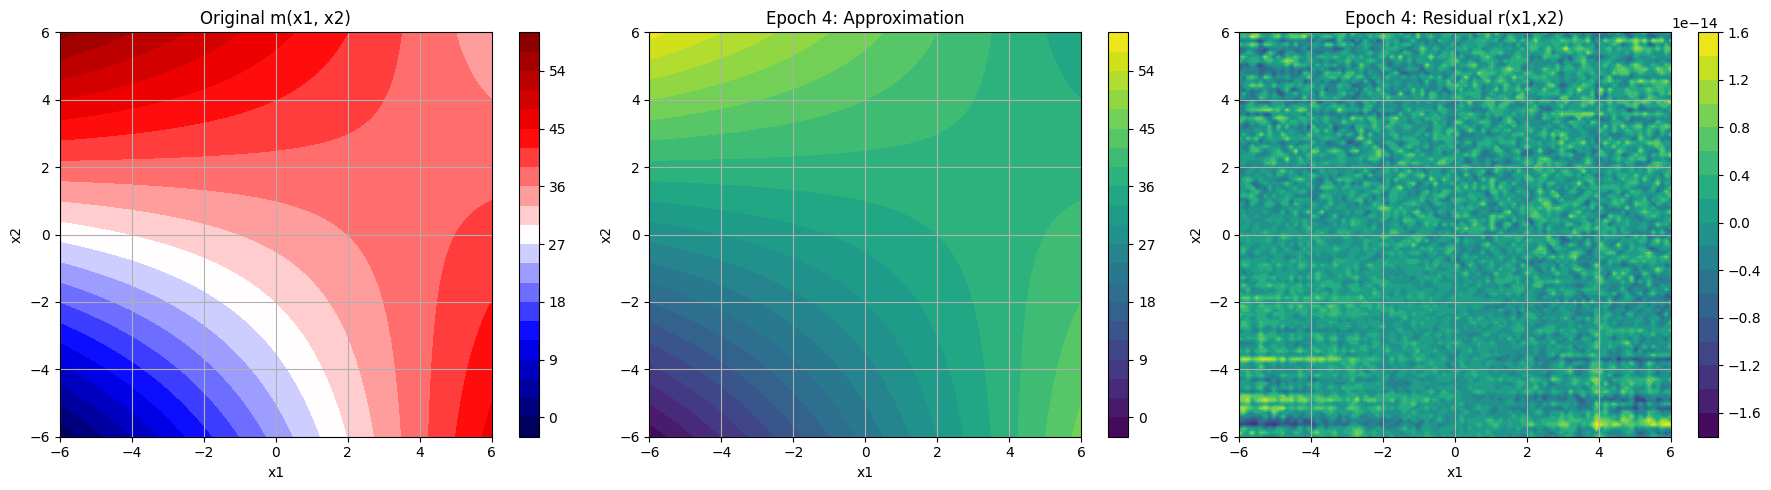

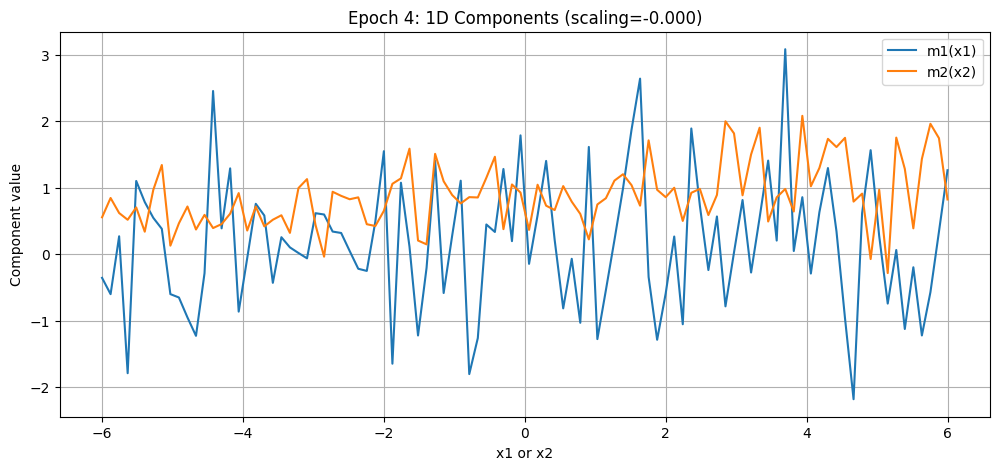

Epoch 5, max residual = 1.770300194886285e-14
Converged after 11 iterations
min(m1) = -1.9205413270384184, min(m2) = -3.572097725787873, residual norm = 3.1355234688071787e-13


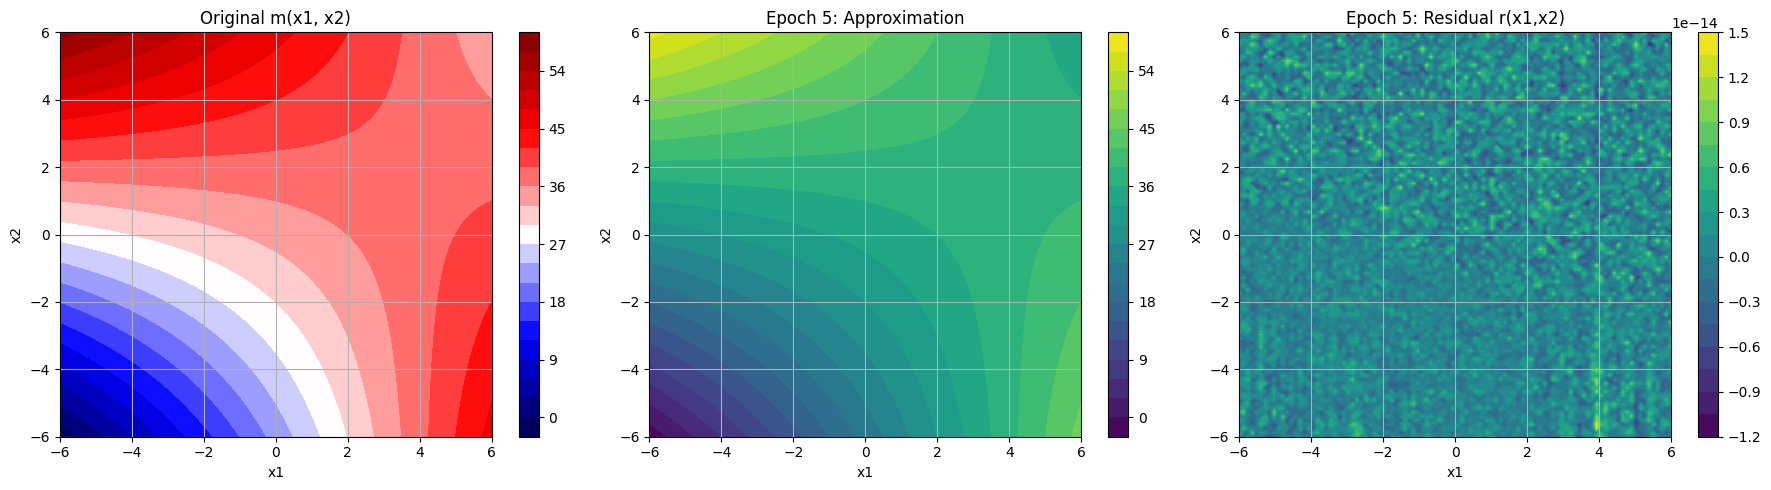

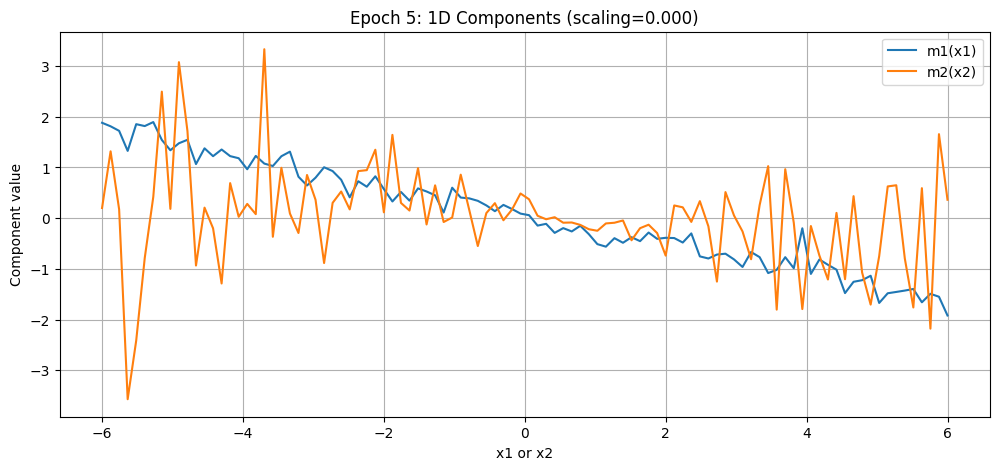

Epoch 6, max residual = 1.3598400589365982e-14
Converged after 32 iterations
min(m1) = -4.759333684525208, min(m2) = -2.509266379052718, residual norm = 3.017303621654686e-13


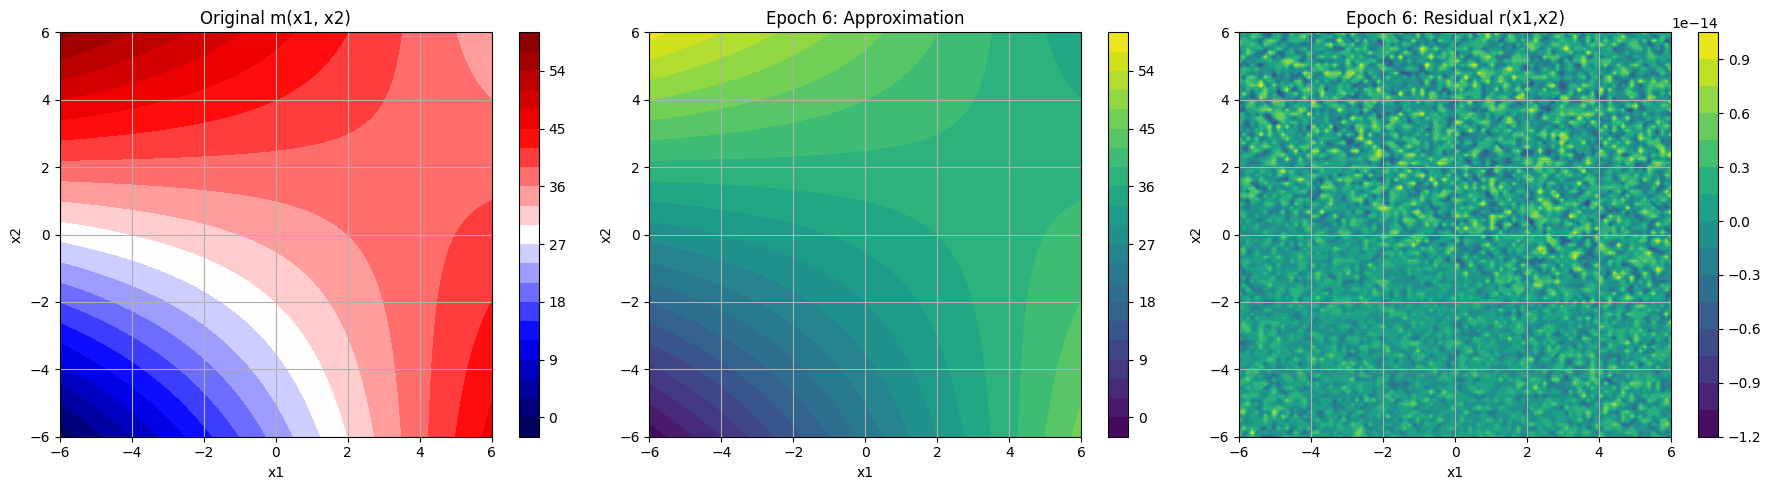

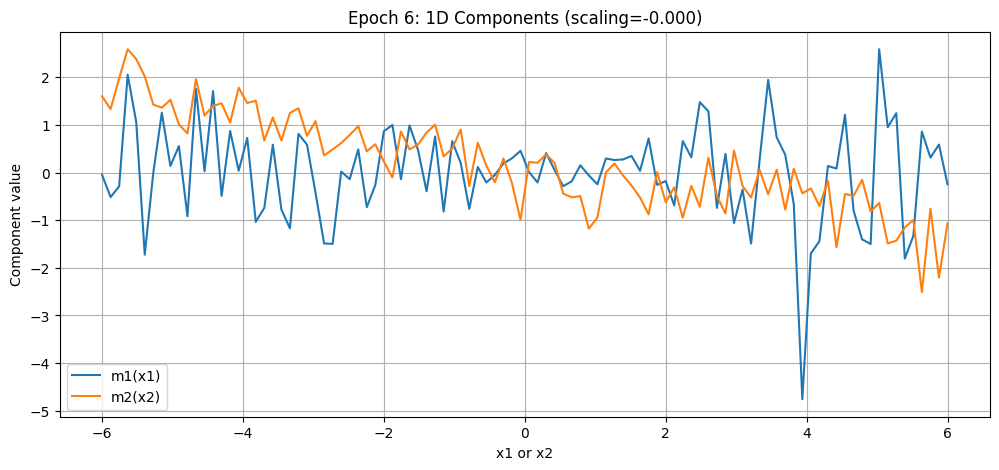

Epoch 7, max residual = 1.1453875358426507e-14
Converged after 480 iterations
min(m1) = -2.892685841339603, min(m2) = -2.9905162582146554, residual norm = 2.948737328385506e-13


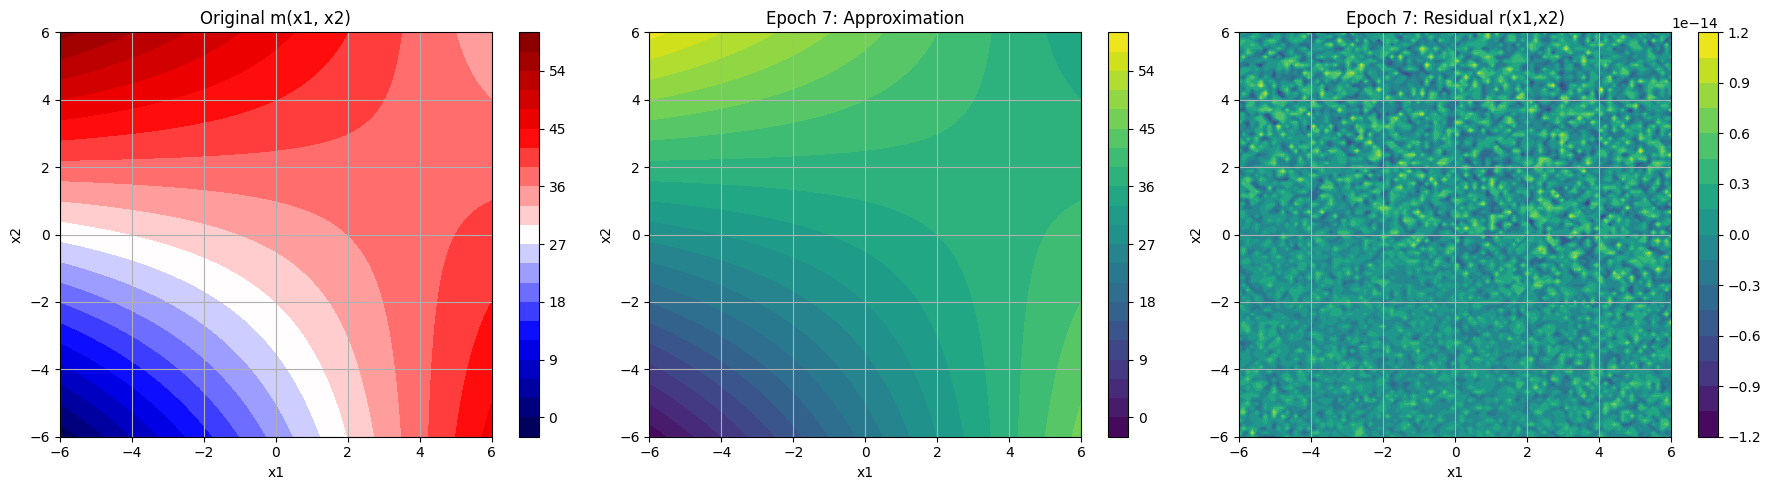

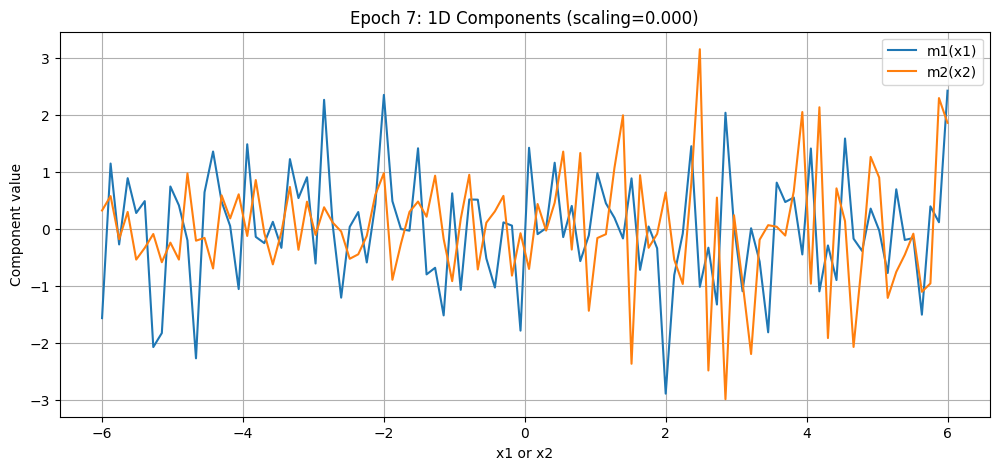

In [ ]:
m_function =  lambda x1, x2: x1 + 2*x2 - .5*x1*x2 + 34 # Use the true_model3 function from utils.py

# Run the iterative projection procedure.
n_epochs = 7
range4 = (-4, 4)
range6 = (-6, 6)

overall_approx, final_residual, components = iterative_projection(
    m_function, n_epochs=n_epochs, x1_range=range6, x2_range=range6,
    num_points=100, tol=1e-6, max_iter=1000, plot=True)


 ## Final Comparison Plot



 Here we compare the original function, the overall approximation obtained by summing the rank‑1 components, and the final residual.

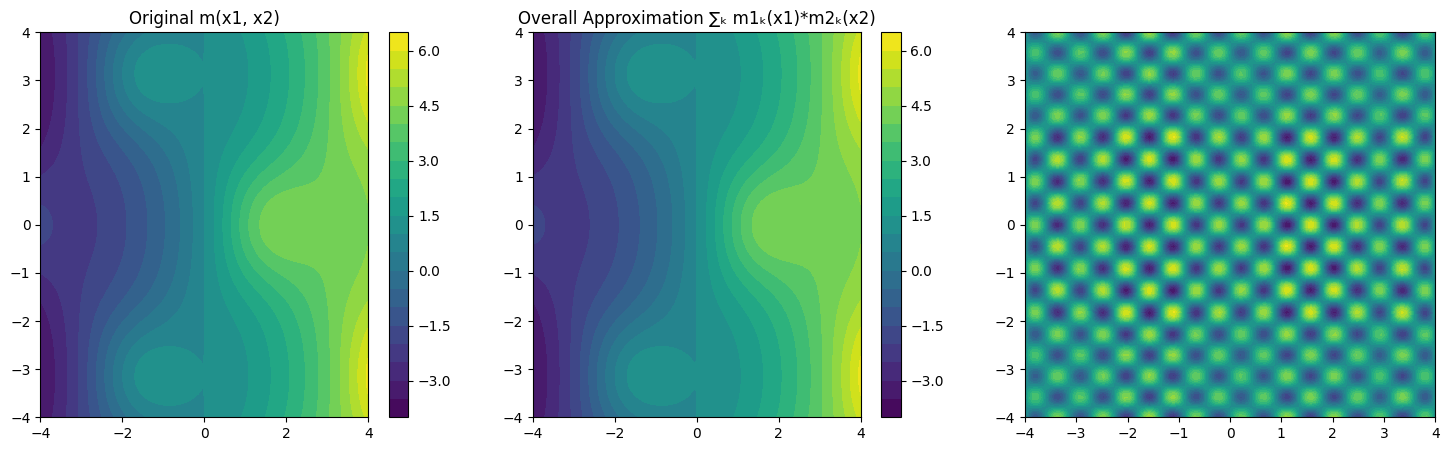

/var/folders/1y/0ltq_3l11sj38950rdf6b8lm0000gn/T/ipykernel_30707/437159628.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 1800x500 with 6 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(c2, ax=axes[2])


<Figure size 640x480 with 0 Axes>

In [9]:
x1_grid = np.linspace(-4, 4, 100)
x2_grid = np.linspace(-4, 4, 100)
X1, X2 = np.meshgrid(x1_grid, x2_grid, indexing='ij')
M_original = m_function(X1, X2)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
c0 = axes[0].contourf(X1, X2, M_original, levels=20, cmap='viridis')
plt.colorbar(c0, ax=axes[0])
axes[0].set_title('Original m(x1, x2)')

c1 = axes[1].contourf(X1, X2, overall_approx, levels=20, cmap='viridis')
plt.colorbar(c1, ax=axes[1])
axes[1].set_title('Overall Approximation ∑ₖ m1ₖ(x1)*m2ₖ(x2)')

c2 = axes[2].contourf(X1, X2, M_original - overall_approx, levels=20, cmap='viridis')
plt.show()
plt.tight_layout()
axes[2].set_title('Final Residual')
plt.colorbar(c2, ax=axes[2])
